In [2]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt


In [24]:

train_data = pd.read_csv('data/train.csv', header=None)
test_data = pd.read_csv('data/test.csv', header=None)

In [26]:

X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values
X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values


y_train = np.where(y_train == 0, -1, 1)
y_test = np.where(y_test == 0, -1, 1)


X_train.shape, y_train.shape, X_test.shape, y_test.shape

((872, 4), (872,), (500, 4), (500,))

In [2]:
def svm_loss(w, X, y, C):
    n = X.shape[0]
    hinge_loss = np.maximum(0, 1 - y * (np.dot(X, w)))
    return 0.5 * np.dot(w, w) + C * np.sum(hinge_loss) / n

def svm_subgradient(w, X, y, C):
    n = X.shape[0]
    margins = y * (np.dot(X, w))
    subgrad = np.where(margins < 1, -y[:, None] * X, 0)
    return w + C * np.sum(subgrad, axis=0) / n

def stochastic_subgradient_svm(X, y, C, T, lr_schedule, gamma_0, a=None):
    n, d = X.shape
    w = np.zeros(d)
    losses = []

    for epoch in range(T):
        indices = np.random.permutation(n)
        X, y = X[indices], y[indices]

        for t in range(n):
            step = epoch * n + t + 1
            gamma_t = gamma_0 / (1 + gamma_0 / a * step) if a else gamma_0 / (1 + step)
            
            margin = y[t] * np.dot(X[t], w)
            if margin < 1:
                w = (1 - gamma_t) * w + gamma_t * C * y[t] * X[t]
            else:
                w = (1 - gamma_t) * w

        losses.append(svm_loss(w, X, y, C))

    return w, losses

def calculate_error(w, X, y):
    predictions = np.sign(X @ w)
    return np.mean(predictions != y)

In [30]:
C_values = [100 / 873, 500 / 873, 700 / 873]
T = 100  
gamma_0 = 0.1
a = 1  

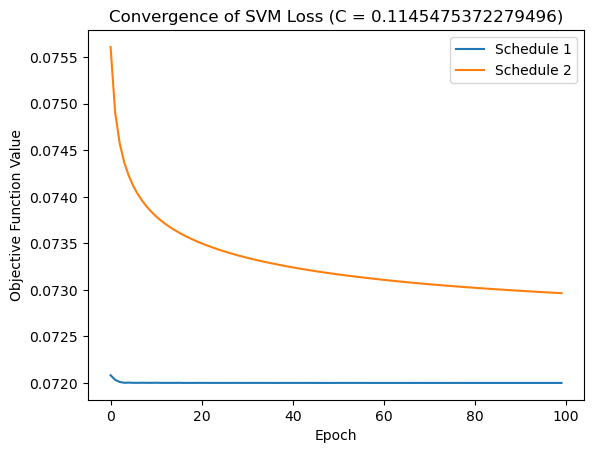

In [32]:
results = {}

for C in C_values:
    w1, losses1 = stochastic_subgradient_svm(X_train, y_train, C, T, "schedule_1", gamma_0, a)
    w2, losses2 = stochastic_subgradient_svm(X_train, y_train, C, T, "schedule_2", gamma_0)
    
    results[C] = {
        "w1": w1,
        "losses1": losses1,
        "w2": w2,
        "losses2": losses2,
    }

for schedule, label in [("losses1", "Schedule 1"), ("losses2", "Schedule 2")]:
    plt.plot(results[C_values[0]][schedule], label=label)

plt.xlabel("Epoch")
plt.ylabel("Objective Function Value")
plt.title("Convergence of SVM Loss (C = {})".format(C_values[0]))
plt.legend()
plt.show()

In [42]:


evaluation_results = {}

for C in C_values:
    result = results[C]
    w1, w2 = result["w1"], result["w2"]
    
    train_error1 = calculate_error(w1, X_train, y_train)
    test_error1 = calculate_error(w1, X_test, y_test)
    
    train_error2 = calculate_error(w2, X_train, y_train)
    test_error2 = calculate_error(w2, X_test, y_test)
    
    evaluation_results[C] = {
        "train_error1": train_error1,
        "test_error1": test_error1,
        "train_error2": train_error2,
        "test_error2": test_error2,
        "parameter_diff": np.linalg.norm(w1 - w2),
        "error_diff_train": abs(train_error1 - train_error2),
        "error_diff_test": abs(test_error1 - test_error2),
    }




In [46]:
evaluation_results

{0.1145475372279496: {'train_error1': 0.12155963302752294,
  'test_error1': 0.136,
  'train_error2': 0.2006880733944954,
  'test_error2': 0.19,
  'parameter_diff': 0.037863528330927945,
  'error_diff_train': 0.07912844036697246,
  'error_diff_test': 0.05399999999999999},
 0.572737686139748: {'train_error1': 0.05619266055045872,
  'test_error1': 0.082,
  'train_error2': 0.06077981651376147,
  'test_error2': 0.078,
  'parameter_diff': 0.014630986391246499,
  'error_diff_train': 0.0045871559633027525,
  'error_diff_test': 0.0040000000000000036},
 0.8018327605956472: {'train_error1': 0.05389908256880734,
  'test_error1': 0.074,
  'train_error2': 0.058486238532110095,
  'test_error2': 0.082,
  'parameter_diff': 0.03783208202125259,
  'error_diff_train': 0.0045871559633027525,
  'error_diff_test': 0.008000000000000007}}

In [50]:
from scipy.optimize import minimize

def dual_svm_objective(alpha, X, y, C):
    n = X.shape[0]
    alpha = alpha.reshape(-1, 1)
    y = y.reshape(-1, 1)
    gram_matrix = np.dot(y * X, (y * X).T)
    return 0.5 * np.dot(alpha.T, np.dot(gram_matrix, alpha)) - np.sum(alpha)

def dual_svm_constraint(alpha, y):
    return np.dot(alpha, y)

def solve_dual_svm(X, y, C):
    n = X.shape[0]
    bounds = [(0, C) for _ in range(n)]
    initial_alpha = np.zeros(n)
    constraints = {'type': 'eq', 'fun': dual_svm_constraint, 'args': (y,)}
    
    result = minimize(
        fun=dual_svm_objective,
        x0=initial_alpha,
        args=(X, y, C),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints
    )
    return result.x

def recover_weights_bias(alpha, X, y, C):
    support_vectors = alpha > 1e-6 
    w = np.sum((alpha[support_vectors] * y[support_vectors])[:, None] * X[support_vectors], axis=0)
    b = np.mean(y[support_vectors] - np.dot(X[support_vectors], w))
    return w, b, np.sum(support_vectors)

In [52]:
dual_results = {}

for C in C_values:
    alpha = solve_dual_svm(X_train, y_train, C)
    w, b, num_support_vectors = recover_weights_bias(alpha, X_train, y_train, C)
    
    dual_results[C] = {
        "w": w,
        "b": b,
        "num_support_vectors": num_support_vectors,
    }

dual_results_df = pd.DataFrame(dual_results).T

C:\Users\Jacob\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


In [53]:
dual_results_df

,w,b,num_support_vectors
0.114548,"[-0.942926518164092, -0.6514917597625467, -0.7...",1.074503,45
0.572738,"[-1.5639408773118184, -1.0140528487340421, -1....",1.512367,31
0.801833,"[-2.042538501415975, -1.280705736694956, -1.51...",1.879352,31
